# Exploratory Data Analysis of the Spotify Tracks Popularity Dataset

Dataset: https://www.kaggle.com/datasets/gauthamvijayaraj/spotify-tracks-dataset-updated-every-week

In [43]:
import os
import sys

sys.dont_write_bytecode = True

import requests
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from dotenv import load_dotenv

from sklearn.model_selection import train_test_split
from scipy.stats import shapiro

load_dotenv()
sns.set_theme()
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

In [44]:
DATA_DIR = './Data/'
FILE = 'spotify_tracks_kaggle_weekly.csv'

data = pd.read_csv(DATA_DIR + FILE)

### Data separation

Splitting the data into train and test sets.\
All analyses will be performed on the training data.

We will be using the same random state and test size for all analyses.

In [45]:
RANDOM_STATE = 21
TEST_SIZE = 0.1

In [46]:
# define target and features
y = data['popularity']
X = data.drop('popularity', axis=1)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [48]:
# Concatenate the training data
data = pd.concat([X_train, y_train], axis=1)

### Null analysis

- Look for missing values 
- Determine impact on the dataset


In [49]:
# first look
data.isnull().sum()

track_id            0
track_name          0
artist_name         0
year                0
artwork_url         0
album_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
track_url           0
language            0
popularity          0
dtype: int64

In [50]:
data.min()

track_id                                       0003ilHWJH7c5UtjKLPiC9
track_name                  "All That Is or Ever Was or Ever Will Be"
artist_name                       "Karaoke - Britney Spears, Madonna"
year                                                             1971
artwork_url                                      No artwork available
album_name                                "Enakke Enakkaa" Love Songs
acousticness                                                     -1.0
danceability                                                     -1.0
duration_ms                                                    5000.0
energy                                                           -1.0
instrumentalness                                                 -1.0
key                                                              -1.0
liveness                                                         -1.0
loudness                                                    -100000.0
mode                

No missing values found at first, but looking at descriptive statistics, we find that they are represented by the value -1.

We know this, because for most of these columns, the dataset states the range of the values being 0-100, or 0.0-1.0.

In [51]:
# count columns with -1 as null
print("Data shape =", data.shape)
data.apply(lambda x: x == -1).sum()

Data shape = (56085, 22)


track_id             0
track_name           0
artist_name          0
year                 0
artwork_url          0
album_name           0
acousticness        31
danceability        31
duration_ms          0
energy              31
instrumentalness    31
key                 31
liveness            31
loudness             0
mode                31
speechiness         31
tempo               31
time_signature      31
valence             31
track_url            0
language             0
popularity           0
dtype: int64

The number of 'null' values is the same for all columns, suggesting that the same rows have missing values for all columns. 

The number is negligable compared to the size of the dataset, so for this analysis we will drop them.

In [52]:
# select given columns
null_columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'key',
                'liveness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']

# drop columns with only -1
data.replace(-1, np.nan, inplace=True)
data = data.dropna(subset=null_columns)
data['key'].value_counts()

key
0.0     7319
7.0     6270
2.0     6155
5.0     5831
9.0     5297
1.0     5138
4.0     4378
11.0    4006
10.0    3553
8.0     3377
6.0     3274
3.0     1456
Name: count, dtype: int64

### Distribution analysis

In [53]:
# split data into numeric and categorical
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])
print(numeric_data.shape, categorical_data.shape)

(56054, 15) (56054, 7)


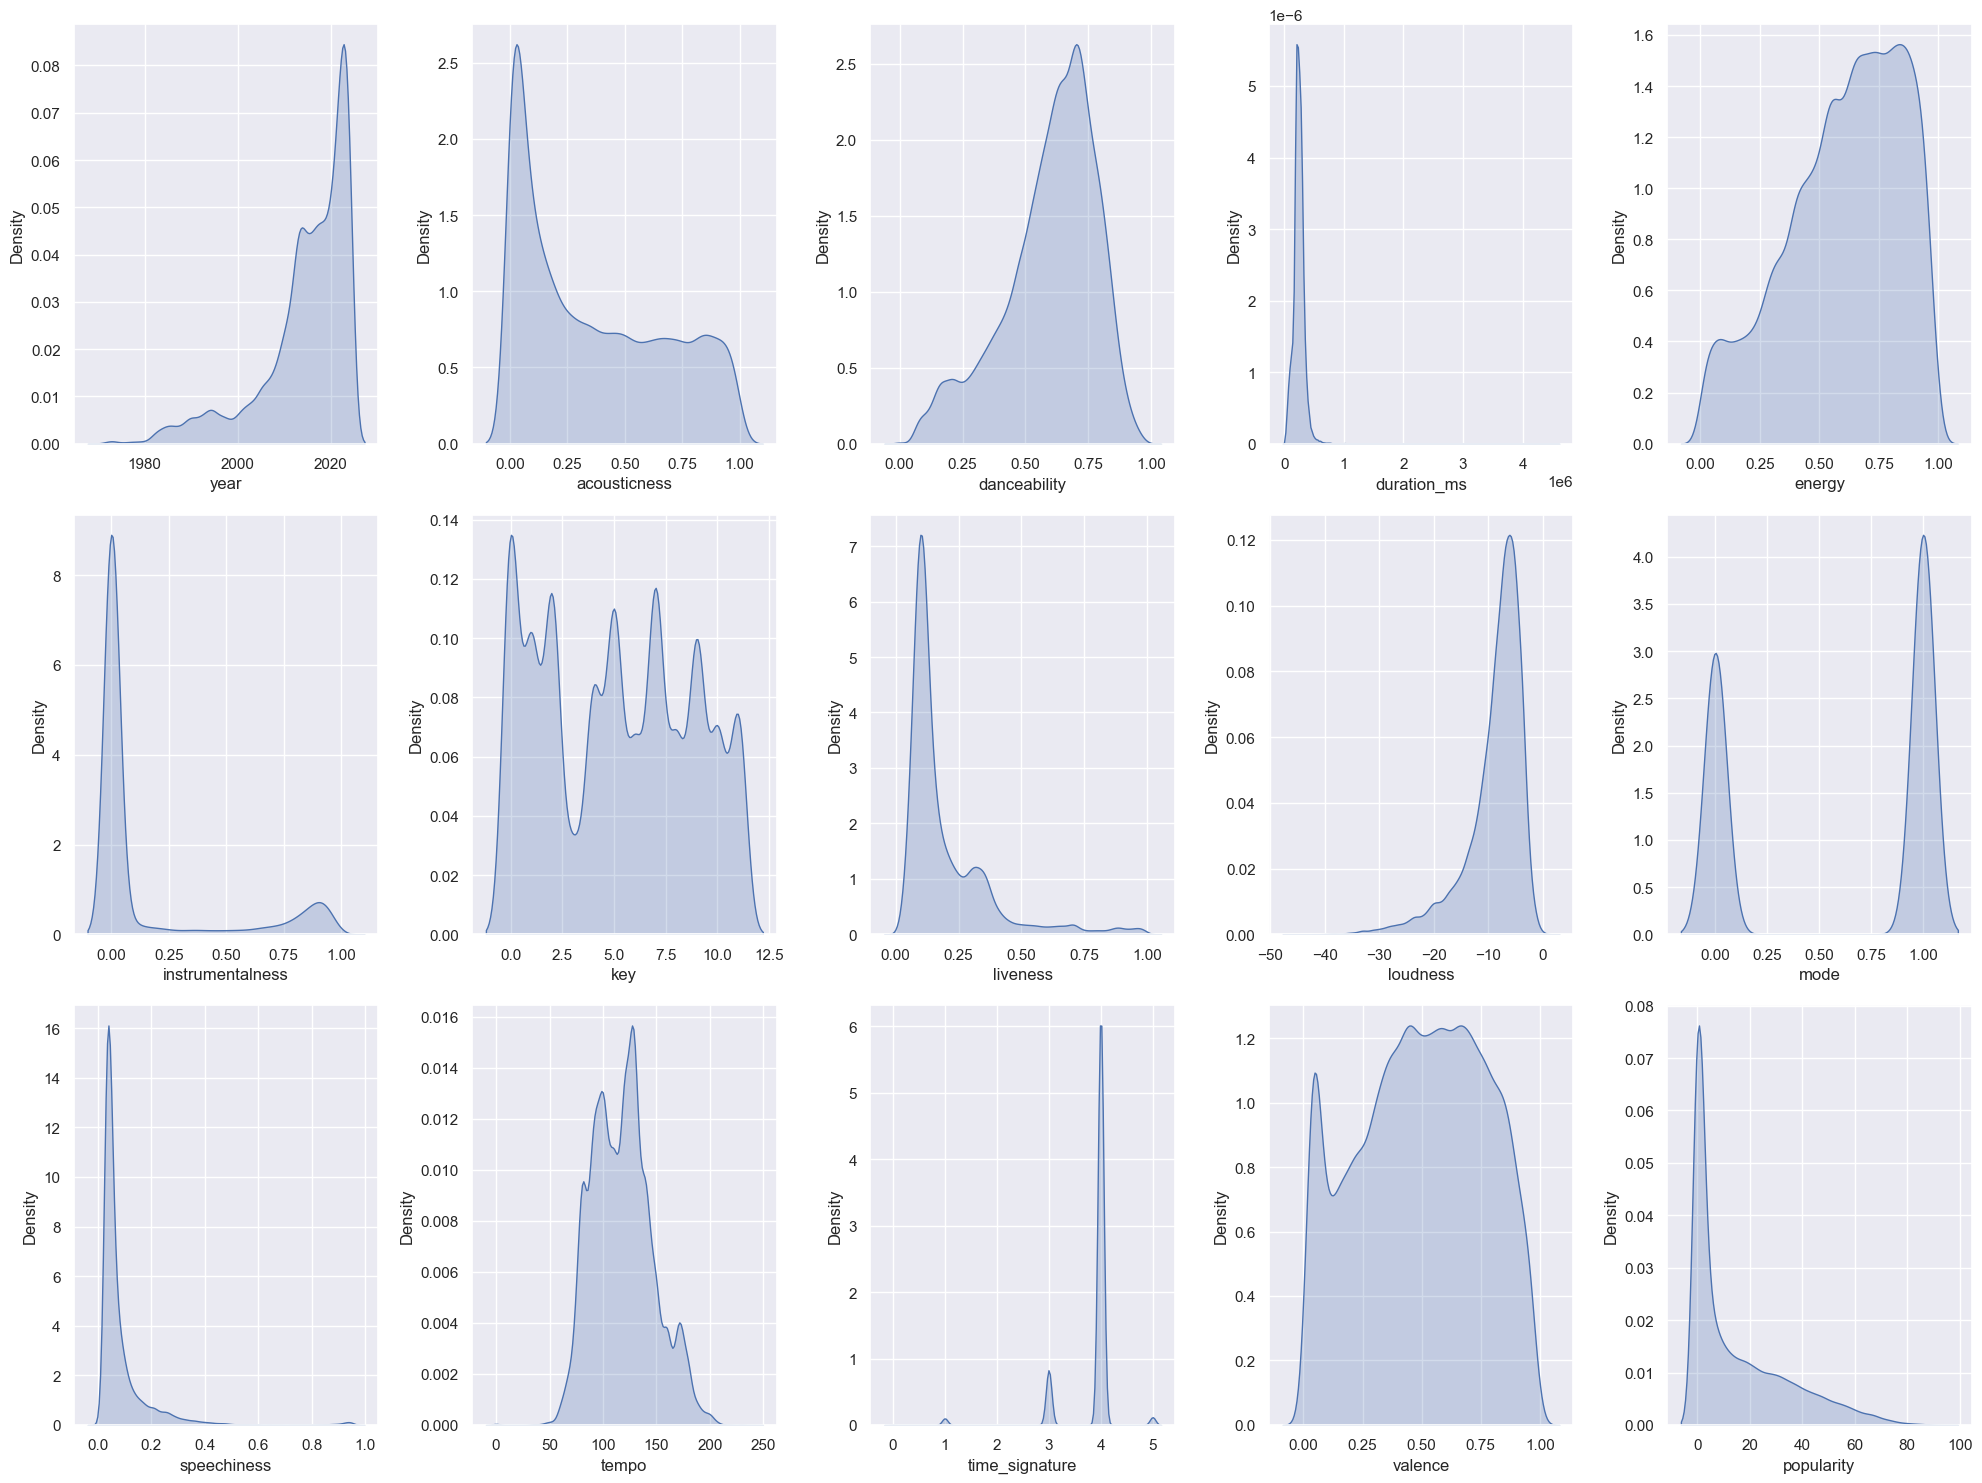

In [54]:
# Plot density of numeric data
fig, axes = plt.subplots(3, 5, figsize=(20, 15))
for i, col in enumerate(numeric_data.columns):
    sns.kdeplot(numeric_data[col], ax=axes[i // 5, i % 5], fill=True)
plt.tight_layout()

After inspection, we can tell that some of the numeric attributes ['key', 'mode', 'time_signature'] are categorical. From the data that we marked categorical, only language seems to be relevant.

In [55]:
categorical_data = pd.concat([categorical_data, data[['key', 'mode', 'time_signature']]], axis=1)
categorical_data = categorical_data.drop(['track_id', 'track_name','artist_name', 'artwork_url', 'album_name', 'track_url'], axis=1).reset_index(drop=True)

numeric_data = numeric_data.drop(['key', 'mode', 'time_signature'], axis=1).reset_index(drop=True)

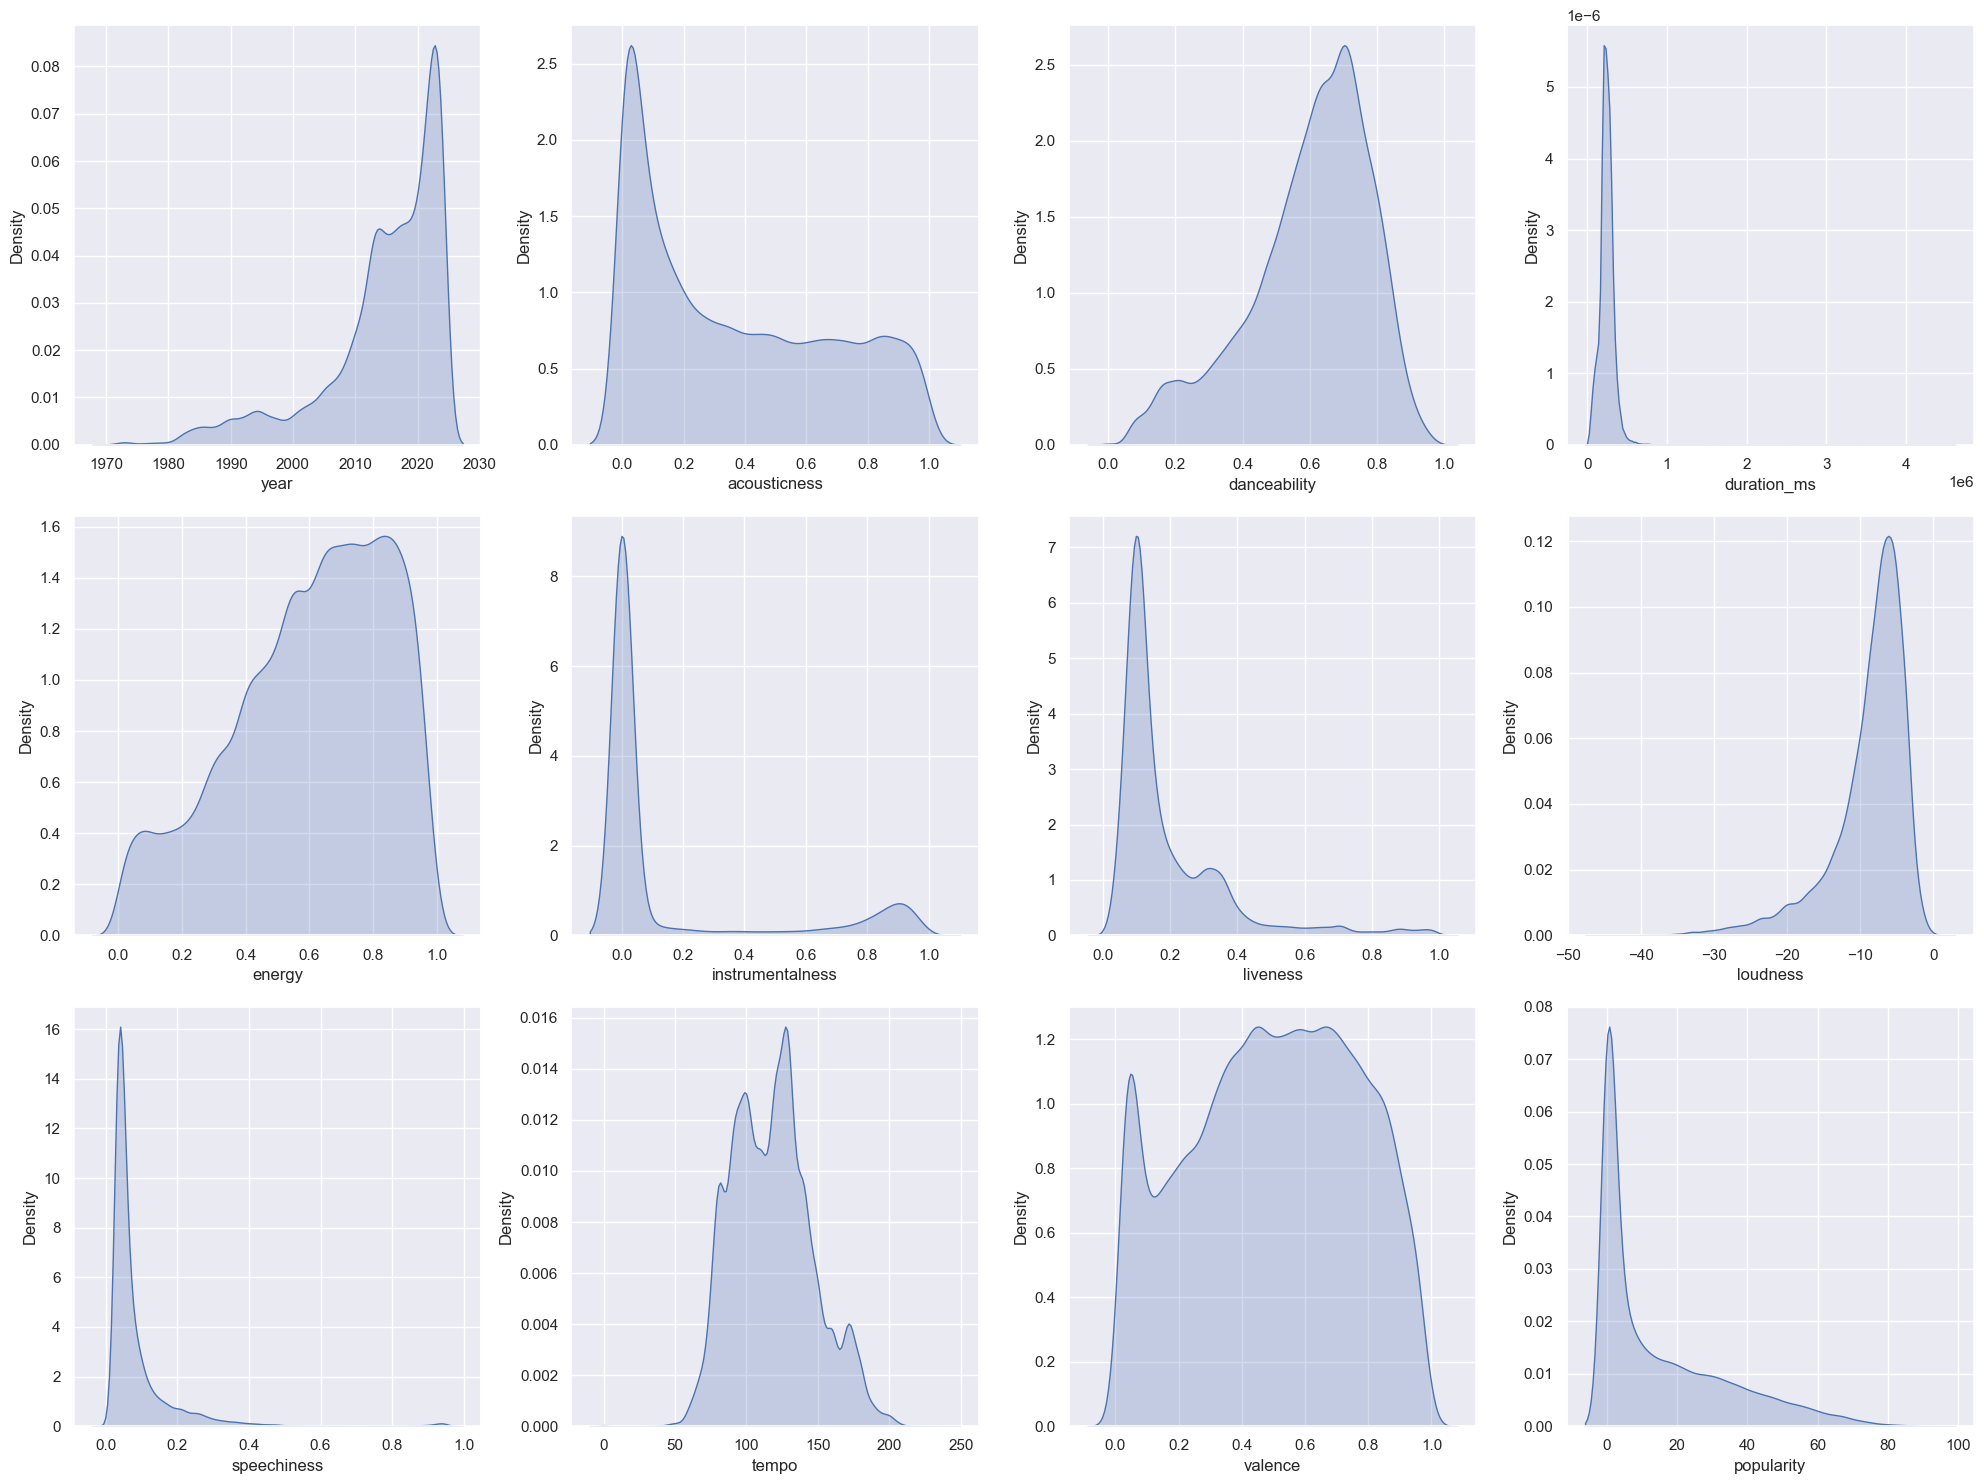

In [58]:
# Plot density of numeric data
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
for i, col in enumerate(numeric_data.columns):
    sns.kdeplot(data[col], ax=axes[i // 4, i % 4], fill=True)
plt.tight_layout()

#### Popularity across song release date - averaging aggregation

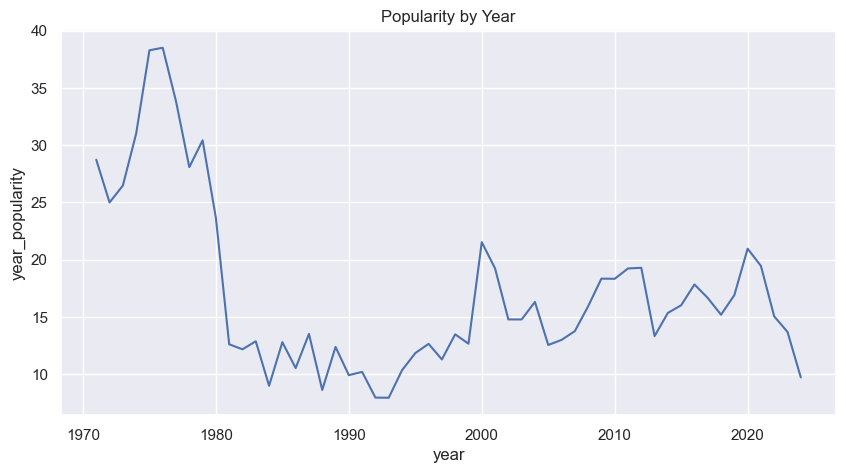

In [73]:
popularity_by_year = data.groupby('year').agg(
    year_popularity = ('popularity', 'mean')
)

popularity_by_year = popularity_by_year.reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=popularity_by_year, x='year', y='year_popularity')
plt.title('Popularity by Year')
plt.show()

We will investigate the count bias -> We compare the counts of songs in a given year to the mean popularity value to see if the popularity is biased by the number of songs released in a given year.

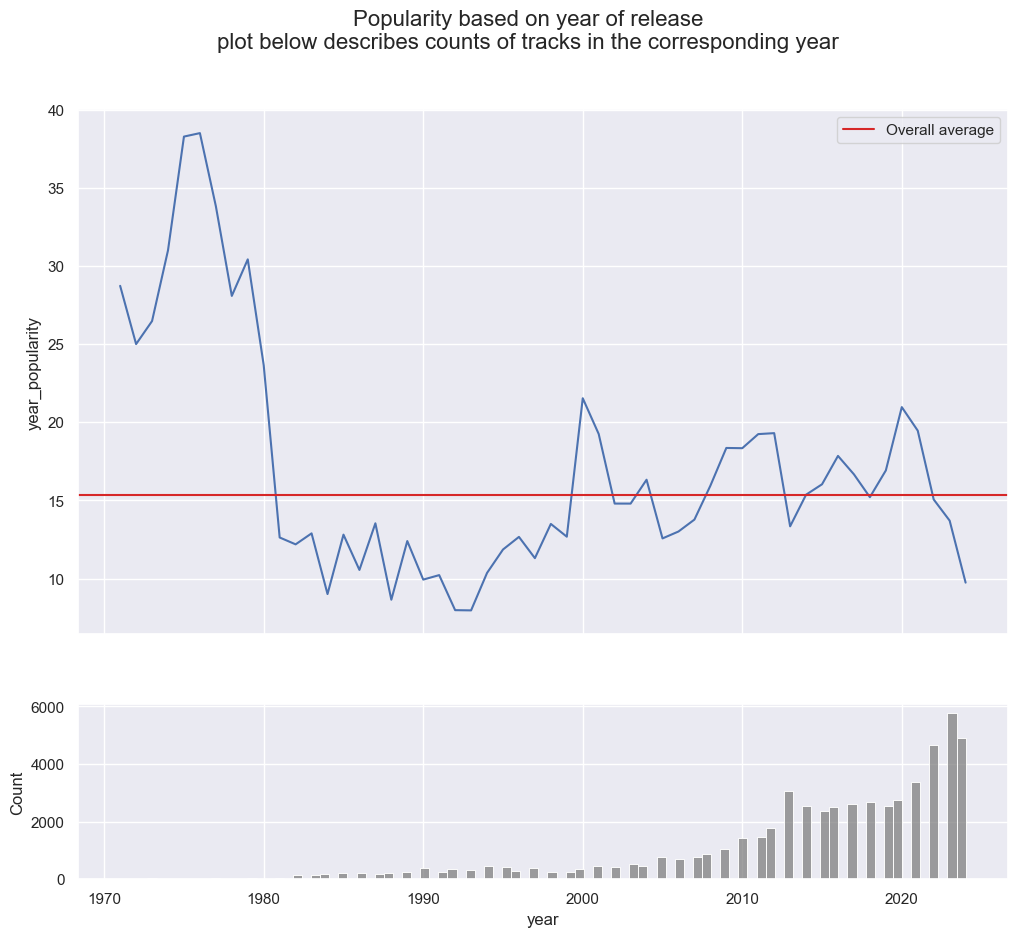

In [85]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

sns.lineplot(data=popularity_by_year, x='year', y='year_popularity', ax=ax[0])
sns.histplot(data=numeric_data, x='year', color='grey')

ax[0].axhline(y=data['popularity'].mean(), color='tab:red', label='Overall average')

ax[0].legend()

# fig.suptitle('Popularity based on year of release\nplot below describes counts of tracks in the corresponding year')
# set title of whole figure
fig.suptitle('Popularity based on year of release\nplot below describes counts of tracks in the corresponding year', fontsize=16)
plt.show()

There could be bias due to the very strong imbalance of counts against the aggregated values.

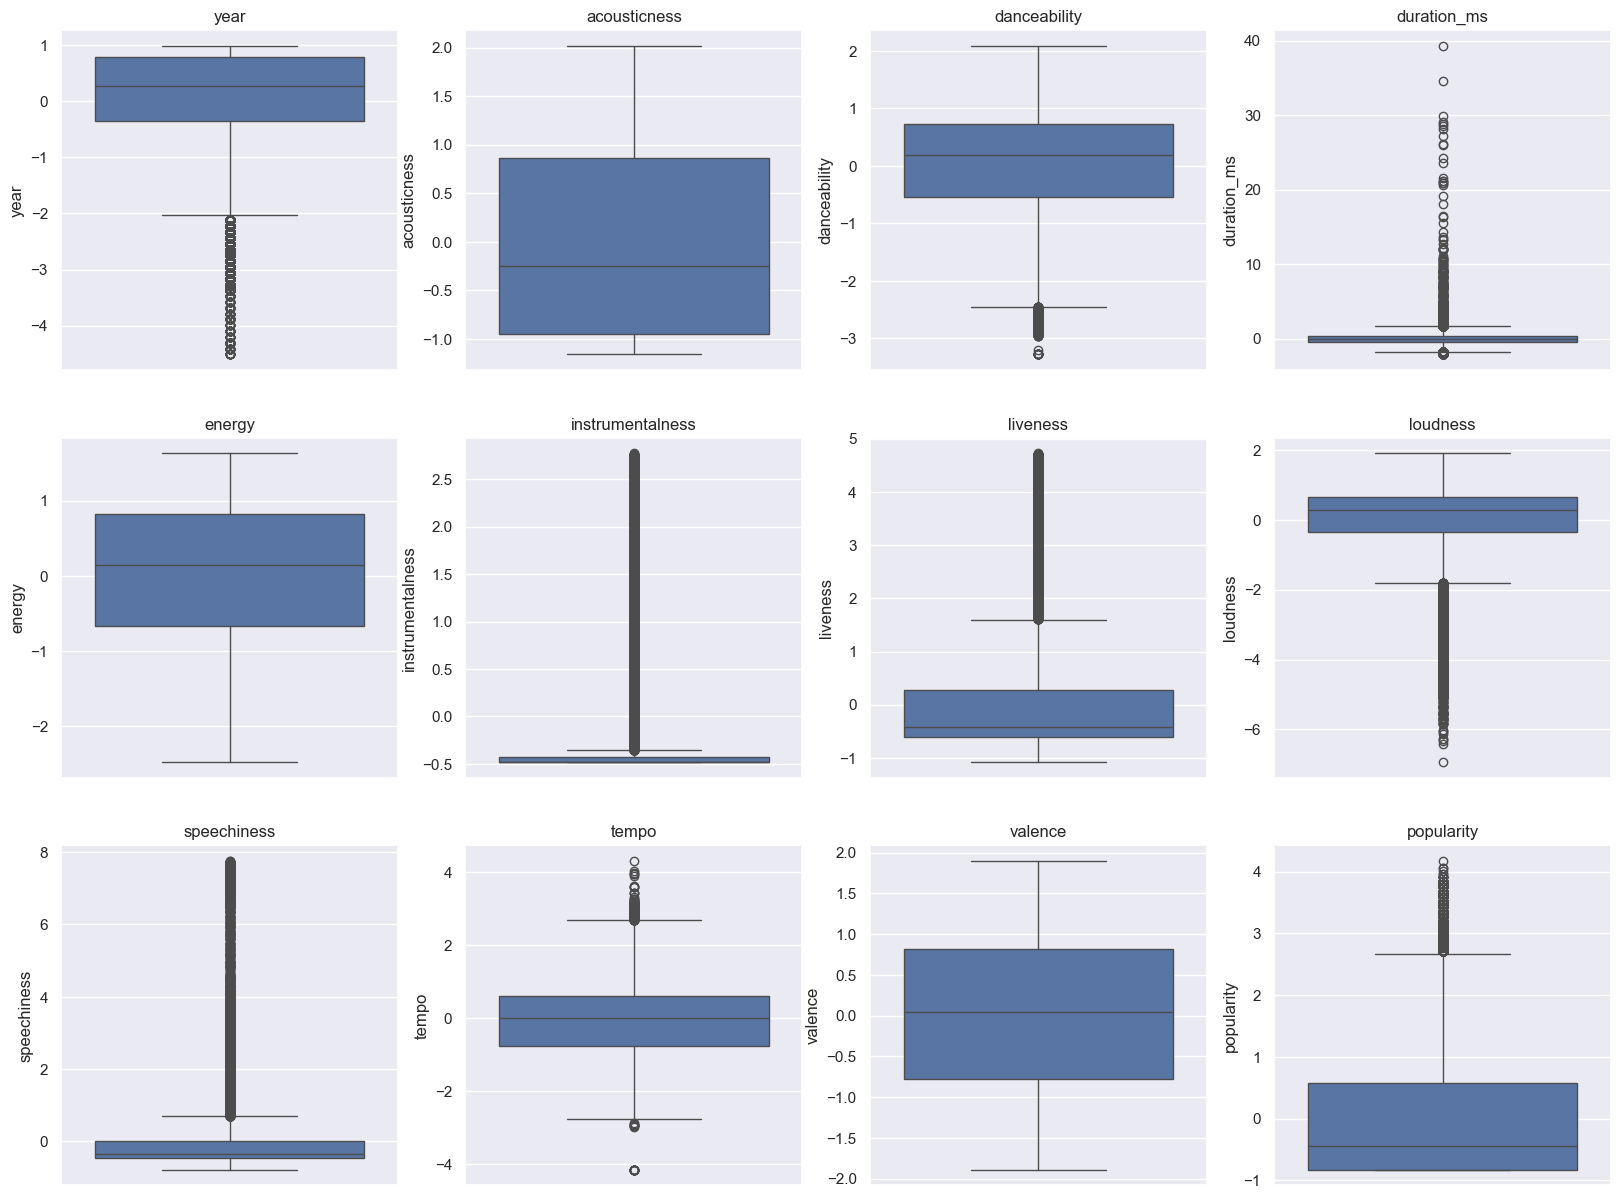

In [88]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

scaled_data = pd.DataFrame(scaled_data, columns=numeric_data.columns)

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
ax = axes.flatten()
for i, col in enumerate(scaled_data.columns):

    column = scaled_data[col]
    sns.boxplot(data=column, ax=ax[i])
    ax[i].set_title(col)
# plt.tight_layout()

It is apparent that outliers are present. 

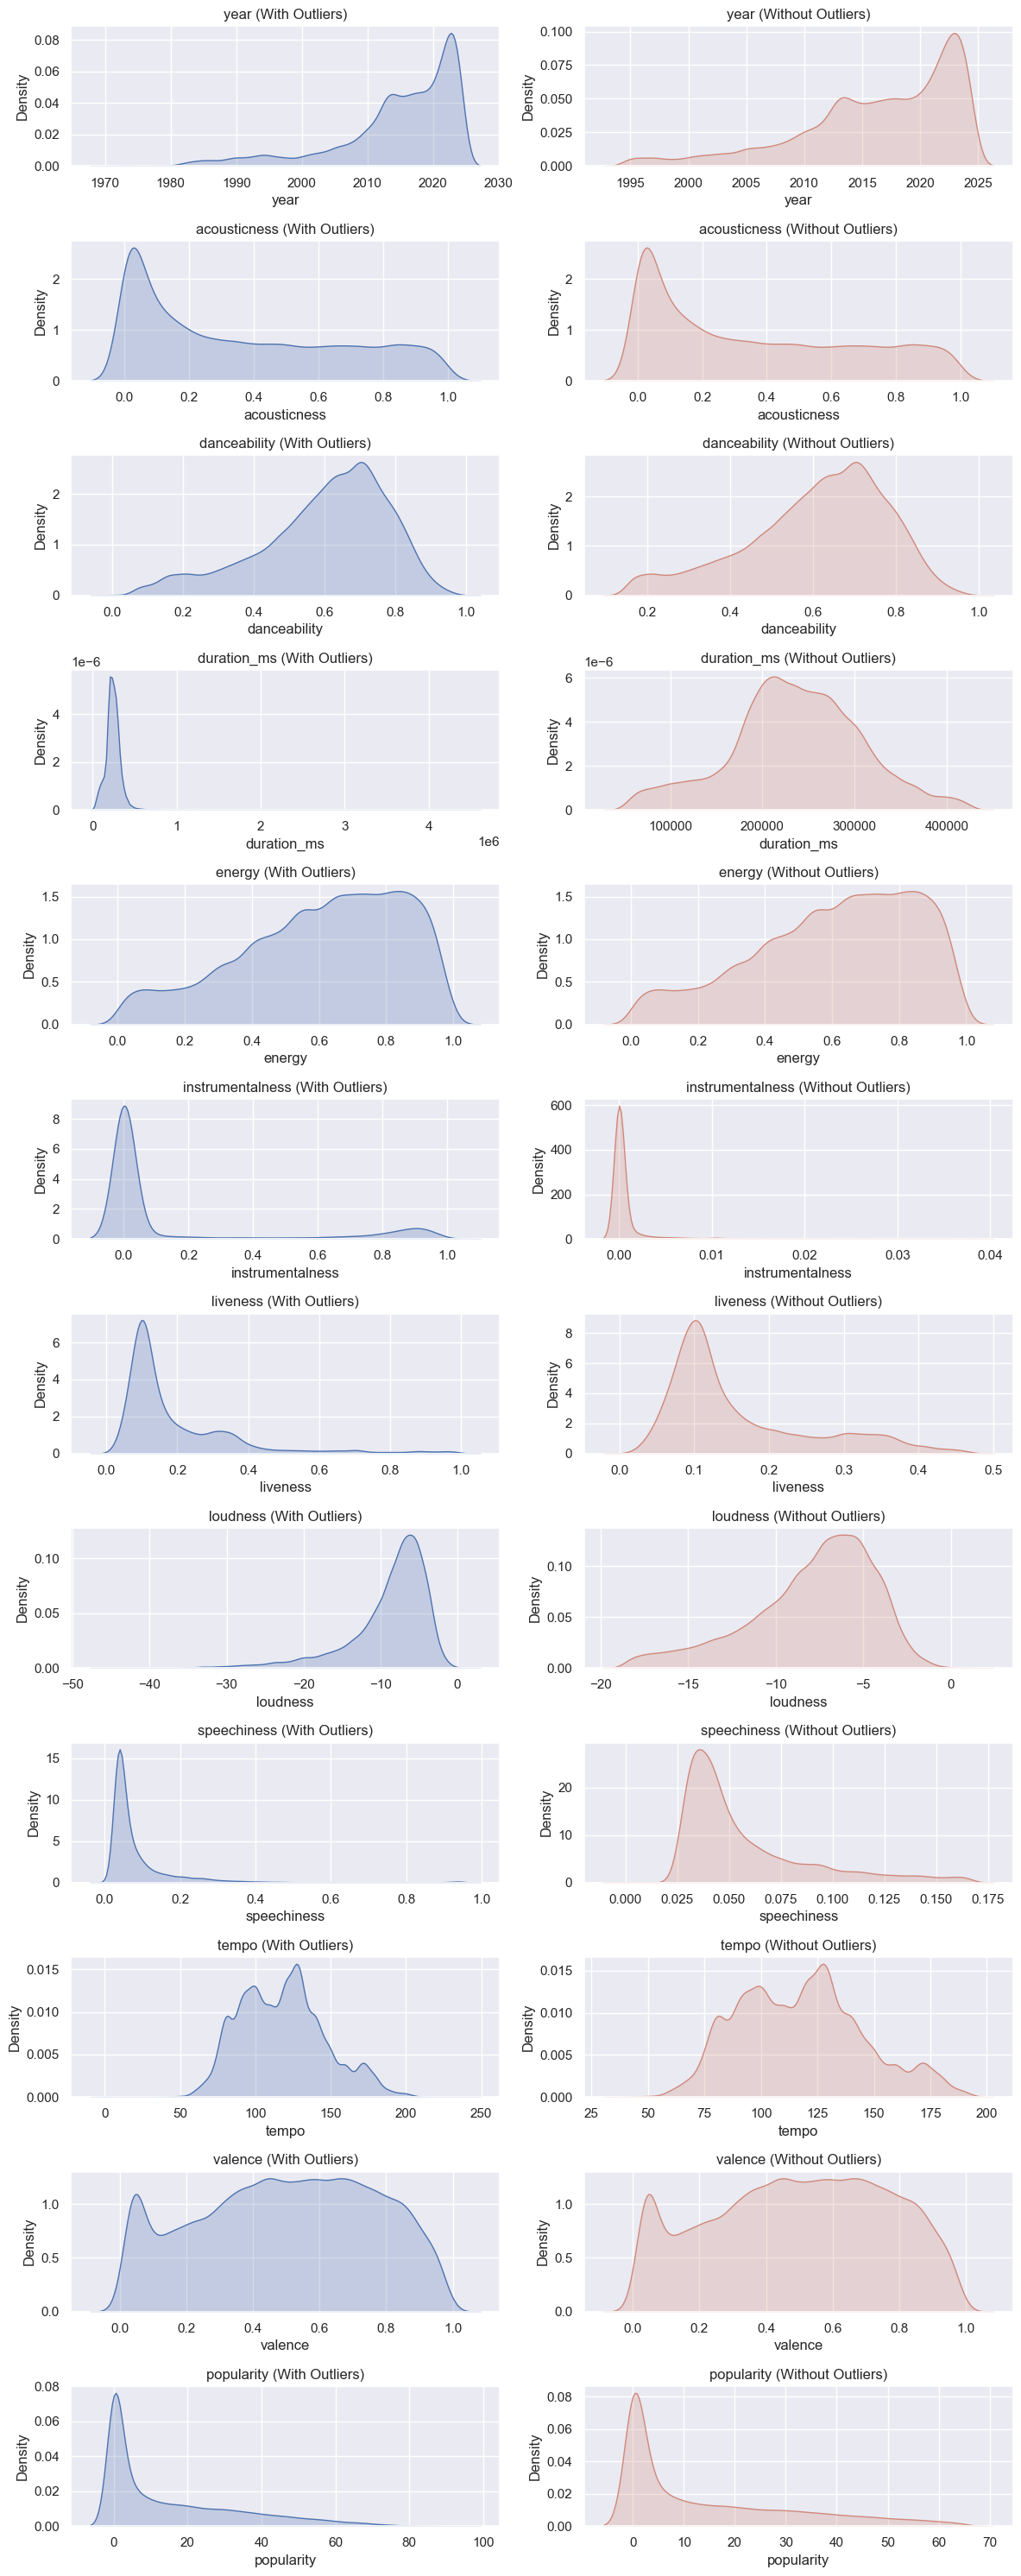

In [99]:
# calculate outlier thresholds
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# print(lower_bound)
# print(upper_bound)

outlierless_data = numeric_data[
    numeric_data.apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name]))
]

num_cols = len(numeric_data.columns)
fig, axes = plt.subplots(nrows=num_cols, ncols=2, figsize=(12, num_cols * 2.5))
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(numeric_data.columns):
    sns.kdeplot(numeric_data[col].dropna(), ax=axes[i, 0], fill=True)
    axes[i, 0].set_title(f"{col} (With Outliers)")
    
    sns.kdeplot(outlierless_data[col].dropna(), ax=axes[i, 1], fill=True, color='#cf887a')
    axes[i, 1].set_title(f"{col} (Without Outliers)")

plt.tight_layout()
plt.show()

### Categorical attributes

In [62]:
categorical_data

,language,key,mode,time_signature
0,English,2.0,0.0,4.0
1,Korean,10.0,1.0,4.0
2,English,6.0,1.0,4.0
3,English,0.0,0.0,4.0
4,Tamil,8.0,1.0,4.0
...,...,...,...,...
56049,Unknown,1.0,1.0,1.0
56050,Hindi,1.0,0.0,4.0
56051,Unknown,10.0,1.0,4.0
56052,Tamil,7.0,0.0,4.0


#### Language

Although not uniform, language distribution is roughly balanced with english not having overwhelming majority.

<Axes: xlabel='language'>

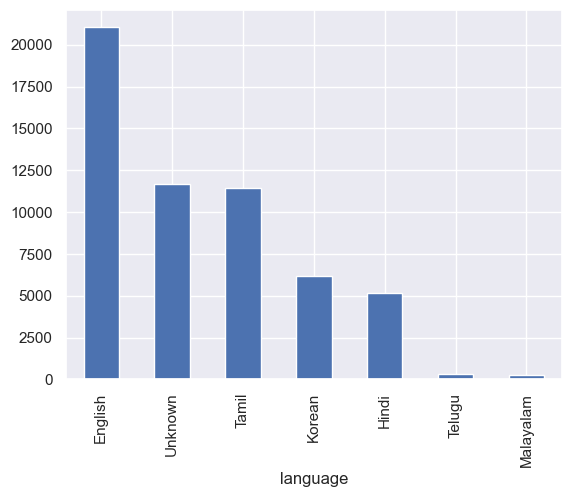

In [63]:
data['language'].value_counts().plot.bar()

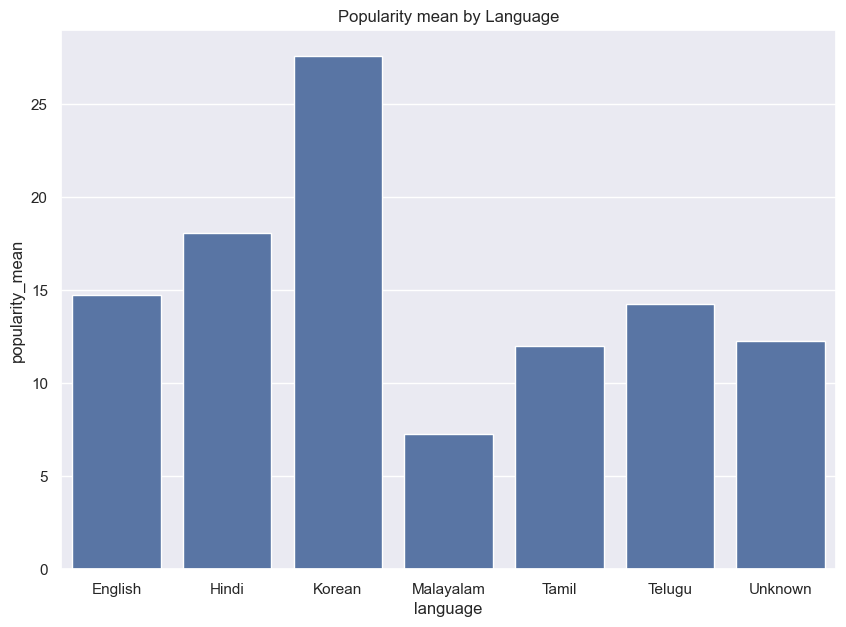

In [104]:
language_popularity = data.groupby('language').agg(
    popularity_mean = ('popularity', 'mean')
)

language_popularity = language_popularity.reset_index()

plt.figure(figsize=(10, 7))
sns.barplot(data=language_popularity, x='language', y='popularity_mean')
plt.title('Popularity mean by Language')
plt.show()

#### key + mode

<Axes: xlabel='key', ylabel='count'>

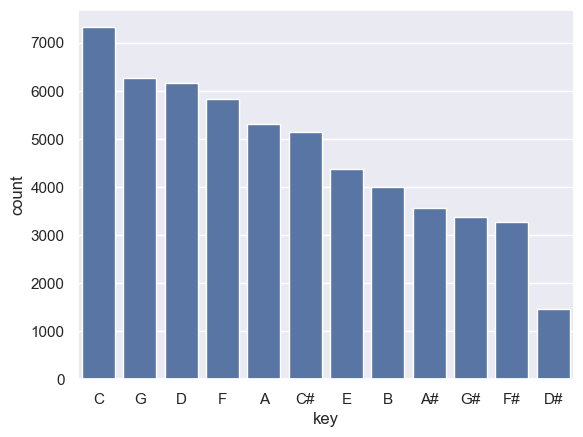

In [65]:
copy_data = data.copy()

# change key from 0 to 11 to  C, c# etc
# copy_data['key'] = copy_data['key'].replace(-1, 'NA')
copy_data['key'] = copy_data['key'].replace(0, 'C')
copy_data['key'] = copy_data['key'].replace(1, 'C#')
copy_data['key'] = copy_data['key'].replace(2, 'D')
copy_data['key'] = copy_data['key'].replace(3, 'D#')
copy_data['key'] = copy_data['key'].replace(4, 'E')
copy_data['key'] = copy_data['key'].replace(5, 'F')
copy_data['key'] = copy_data['key'].replace(6, 'F#')
copy_data['key'] = copy_data['key'].replace(7, 'G')
copy_data['key'] = copy_data['key'].replace(8, 'G#')
copy_data['key'] = copy_data['key'].replace(9, 'A')
copy_data['key'] = copy_data['key'].replace(10, 'A#')
copy_data['key'] = copy_data['key'].replace(11, 'B')

copy_data.sort_values('key', inplace=True)
sns.countplot(x='key', data=copy_data, order=copy_data['key'].value_counts().index)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, 'C Major'),
  Text(1, 0, 'G Major'),
  Text(2, 0, 'D Major'),
  Text(3, 0, 'C# Major'),
  Text(4, 0, 'F Minor'),
  Text(5, 0, 'F Major'),
  Text(6, 0, 'A Major'),
  Text(7, 0, 'A Minor'),
  Text(8, 0, 'B Minor'),
  Text(9, 0, 'G# Major'),
  Text(10, 0, 'E Minor'),
  Text(11, 0, 'C Minor'),
  Text(12, 0, 'A# Minor'),
  Text(13, 0, 'E Major'),
  Text(14, 0, 'F# Minor'),
  Text(15, 0, 'G Minor'),
  Text(16, 0, 'D Minor'),
  Text(17, 0, 'F# Major'),
  Text(18, 0, 'C# Minor'),
  Text(19, 0, 'A# Major'),
  Text(20, 0, 'B Major'),
  Text(21, 0, 'G# Minor'),
  Text(22, 0, 'D# Major'),
  Text(23, 0, 'D# Minor')])

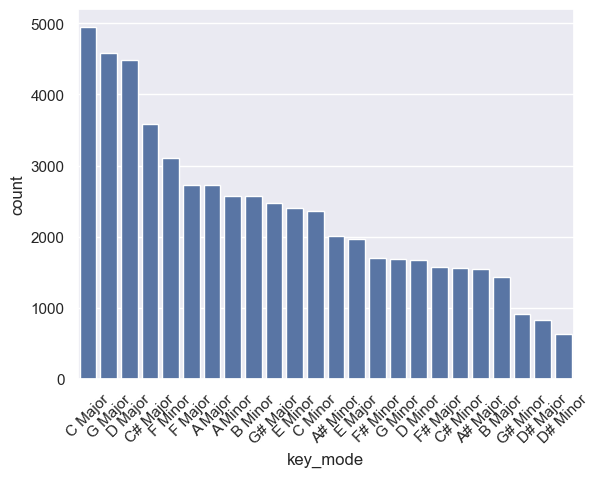

In [66]:
# combine key and mode column

# replace mode numbers with major and minor
copy_data['mode'] = copy_data['mode'].replace(0, 'Minor')
copy_data['mode'] = copy_data['mode'].replace(1, 'Major')

copy_data['key_mode'] = copy_data['key'] + ' ' + copy_data['mode']

sns.countplot(x='key_mode', data=copy_data, order=copy_data['key_mode'].value_counts().index)
plt.xticks(rotation=45)

So the most popular keys are C, G and D major. These are usually associated with happy soundinng melodies and similar. So another thing to look at might be attributes like valence or energy.


#### time signatures

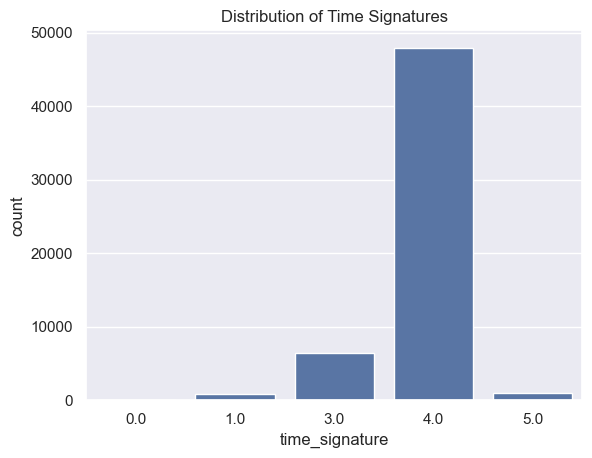

time_signature
4.0    47944
3.0     6404
5.0      911
1.0      775
0.0       20
Name: count, dtype: int64

In [67]:
sns.countplot(x='time_signature', data=data)
plt.title('Distribution of Time Signatures')
plt.show()
data['time_signature'].value_counts()

The dataset described the column as ranging from 3/4 to 7/4, yet we also see values -1 (removed), 0 and 1. (we expected values from 3 - 7). 
We can see that the two most common time signatures are 4/4(standard) and 3/4(waltz) which was to be expected.

Since this audio feature is just estimated using some machine learning model and time signatures outside these two are not that common, 
the models dont really have the capacity to categorize them correctly, so there is also a possibility that a lot of 4/4 and 3/4 ts are misclassified.

The description of this attribute is not very clear and it is not very apparent what the values 0 and 1 represent.

In [68]:
# rows with time signature 0,-1,1
data[(data['time_signature'] == 0)].head()
data[(data['time_signature'] == -1)].head()
data[(data['time_signature'] == 1)].head()

,track_id,track_name,artist_name,year,artwork_url,album_name,acousticness,danceability,duration_ms,energy,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,track_url,language,popularity
60718,4PH6ijsaaAmo2Ahv2nkjJ6,Chapter 111 - The Boat House - The BRAND NEW p...,"Keri Beevis, Shakira Shute",2023,https://i.scdn.co/image/ab67616d0000b27388315d...,The Boat House [The BRAND NEW page-turning psy...,0.416,0.623,181804.0,0.1390,...,0.1520,-17.747,0.0,0.9240,175.494,1.0,0.3940,https://open.spotify.com/track/4PH6ijsaaAmo2Ah...,English,0
10006,5v61WbyzD0dySPDpPHl8md,Kanava Illai Kaatra,"A.R. Rahman, Vairamuthu, Hariharan, Sujatha",2023,https://i.scdn.co/image/ab67616d0000b273c028a9...,Ratchagan (Original Motion Picture Soundtrack),0.613,0.687,274120.0,0.2470,...,0.0976,-11.466,1.0,0.0338,114.784,1.0,0.3850,https://open.spotify.com/track/5v61WbyzD0dySPD...,Unknown,11
9842,6KxrZuLkjLz76txdWWC5kA,Pandyan's Invade,A.R. Rahman,2024,https://i.scdn.co/image/ab67616d0000b2735898fc...,Ponniyin Selvan (Original Score),0.327,0.424,142730.0,0.4560,...,0.3730,-17.136,1.0,0.0678,107.900,1.0,0.0353,https://open.spotify.com/track/6KxrZuLkjLz76tx...,Unknown,15
51958,6U1tR1vVSoLQAbxrS3lyUu,High Places,The Afrikana Madonna,2007,https://i.scdn.co/image/ab67616d0000b273ac5401...,Like Manna For The Soul,0.966,0.468,142760.0,0.0737,...,0.2090,-12.435,1.0,0.2290,137.436,1.0,0.1560,https://open.spotify.com/track/6U1tR1vVSoLQAbx...,English,0
7712,4VIIq0VDjKdXXEKxhM3ua6,Loss Is All That Is Left,Arijit Singh,2021,https://i.scdn.co/image/ab67616d0000b273e9528a...,Pagglait (Original Motion Picture Soundtrack),0.986,0.081,76845.0,0.0955,...,0.1260,-14.755,0.0,0.0358,171.124,1.0,0.0447,https://open.spotify.com/track/4VIIq0VDjKdXXEK...,Hindi,3


Entries with 0,-1 or 1 time signature have either extremely low popularity and other scores or completely invalid values (negative values for acousticness, danceability etc), some entries that might be considered either dropping or ignoring 

### Correlation analysis

In [69]:
num_copy_data = numeric_data.copy()


corr = num_copy_data.corr()['popularity'].sort_values(ascending=False)

corr

popularity          1.000000
loudness            0.202277
energy              0.149057
danceability        0.042019
tempo               0.027032
year                0.016648
valence             0.009365
liveness           -0.012182
duration_ms        -0.040907
speechiness        -0.052685
instrumentalness   -0.125927
acousticness       -0.139432
Name: popularity, dtype: float64

*contrary to previous assumption, despite the three major keys c,g,d being the most popular (which are usually associated with happy mood) here, valence has the smallest correlation with popularity of a track(valence describes musical positivity of the track)*

Relevant correlations to popularity:
positive:
- loudness (0.20)
- energy (0.15)

negative:
- acousticness (-0.14)
- instrumentalness (-0.13)
- speechiness (-0.05)

### Normality testing

Shapiro-Wilk normality tests -> we will use p-value treshold = 5%

In [70]:
p_value_treshold = 0.05

In [71]:
for col in numeric_data:
    
    column = numeric_data[col]

    _, p_value = shapiro(column)

    if p_value < p_value_treshold:
        print(f"Rejects hypothesis H0 for column {col:<20} with p-value = {p_value:.3f} ---> NO NORMAL DISTRIBUTION")

Rejects hypothesis H0 for column year                 with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column acousticness         with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column danceability         with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column duration_ms          with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column energy               with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column instrumentalness     with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column liveness             with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column loudness             with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column speechiness          with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column tempo                with p-value = 0.00